In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import glob
import os
import cv2
from patchify import patchify
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from patchify import unpatchify

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# Load the model you trained in task5_training.ipynb
#from tensorflow.keras.models import load_model
patch_size = 256
#example_file_name = f'emil_231007_unet_model_{patch_size}px.h5'
#model = load_model(example_file_name, custom_objects={"f1": f1})

In [4]:
from tensorflow.keras.models import load_model

model_path = r"C:\Users\emilp\Downloads\INPUT_model\model.keras"  # folder, not a .pb file

model = load_model(model_path, custom_objects={"f1": f1})

print("Model loaded successfully.")

Model loaded successfully.


In [5]:
def crop_petri_dish(image):

    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    blurred = cv2.GaussianBlur(gray_image, (9, 9), 0)

    _, thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY) 
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = [cnt for cnt in contours if cv2.contourArea(cnt) < image.shape[0] * image.shape[1] * 0.95]

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    image = image[y:y+h, x:x+w]

    return image, (x, y, w, h)

In [6]:
def crop_petri_dish(image):

    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    # apply Gaussian Blur to smooth the image
    blurred = cv2.GaussianBlur(gray_image, (9, 9), 0)
    # apply binary threshold
    _, thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY) 
    
    # finding contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # filtering out very large contours which might be the image borders
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) < image.shape[0] * image.shape[1] * 0.95]

    # findng the largest contour which will be the petri dish
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # modify the bounding rectangle to crop more tightly, the margin can be changed
    margin = 90
    x += margin
    y += margin
    w -= 2 * margin
    h -= 2 * margin
    
    # ensuring the modified coordinates are within image bounds
    x = max(x, 0)
    y = max(y, 0)
    w = min(w, image.shape[1] - x)
    h = min(h, image.shape[0] - y)

    # cropping the image based on calculated coordinates
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image, (x, y, w, h)

In [7]:
def apply_crop(image, bbox):
    x, y, w, h = bbox
    return image[y:y+h, x:x+w]

In [8]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return image

In [9]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
#image = cv2.imread(task5_test_image_path, cv2.IMREAD_COLOR)
image = cv2.imread(task5_test_image_path, cv2.IMREAD_COLOR)
h, w, c = image.shape
print(h, w, c)

3006 4112 3


In [10]:
petri_dish, bbox = crop_petri_dish(image)
#petri_dish = apply_crop(image, bbox)
petri_dish.shape

(2727, 2724, 3)

In [11]:
petri_dish_padded = padder(petri_dish, patch_size)
petri_dish_padded.shape

(2816, 2816, 3)

In [12]:
image_patches = patchify(petri_dish_padded, (patch_size, patch_size, 3), step=patch_size)

In [13]:
image_patches = np.squeeze(image_patches)

In [14]:
image_patches.shape

(11, 11, 256, 256, 3)

In [15]:
i = image_patches.shape[0]
j = image_patches.shape[1] 

In [16]:
image_patches_reshaped = image_patches.reshape(-1, patch_size, patch_size, 3)
image_patches_reshaped.shape

(121, 256, 256, 3)

In [17]:
predicted_mask = model.predict(image_patches_reshaped/255)

4/4 [==============================] - 4s 786ms/step


In [18]:
predicted_mask = predicted_mask.reshape(i, j, 256, 256) 

In [19]:
predicted_mask.shape

(11, 11, 256, 256)

In [20]:
num_patches = predicted_mask.shape[0]

target_shape = (num_patches * patch_size, num_patches * patch_size)

# Reconstruct the mask
predicted_mask = unpatchify(predicted_mask, target_shape)

Text(0.5, 1.0, 'Prediction')

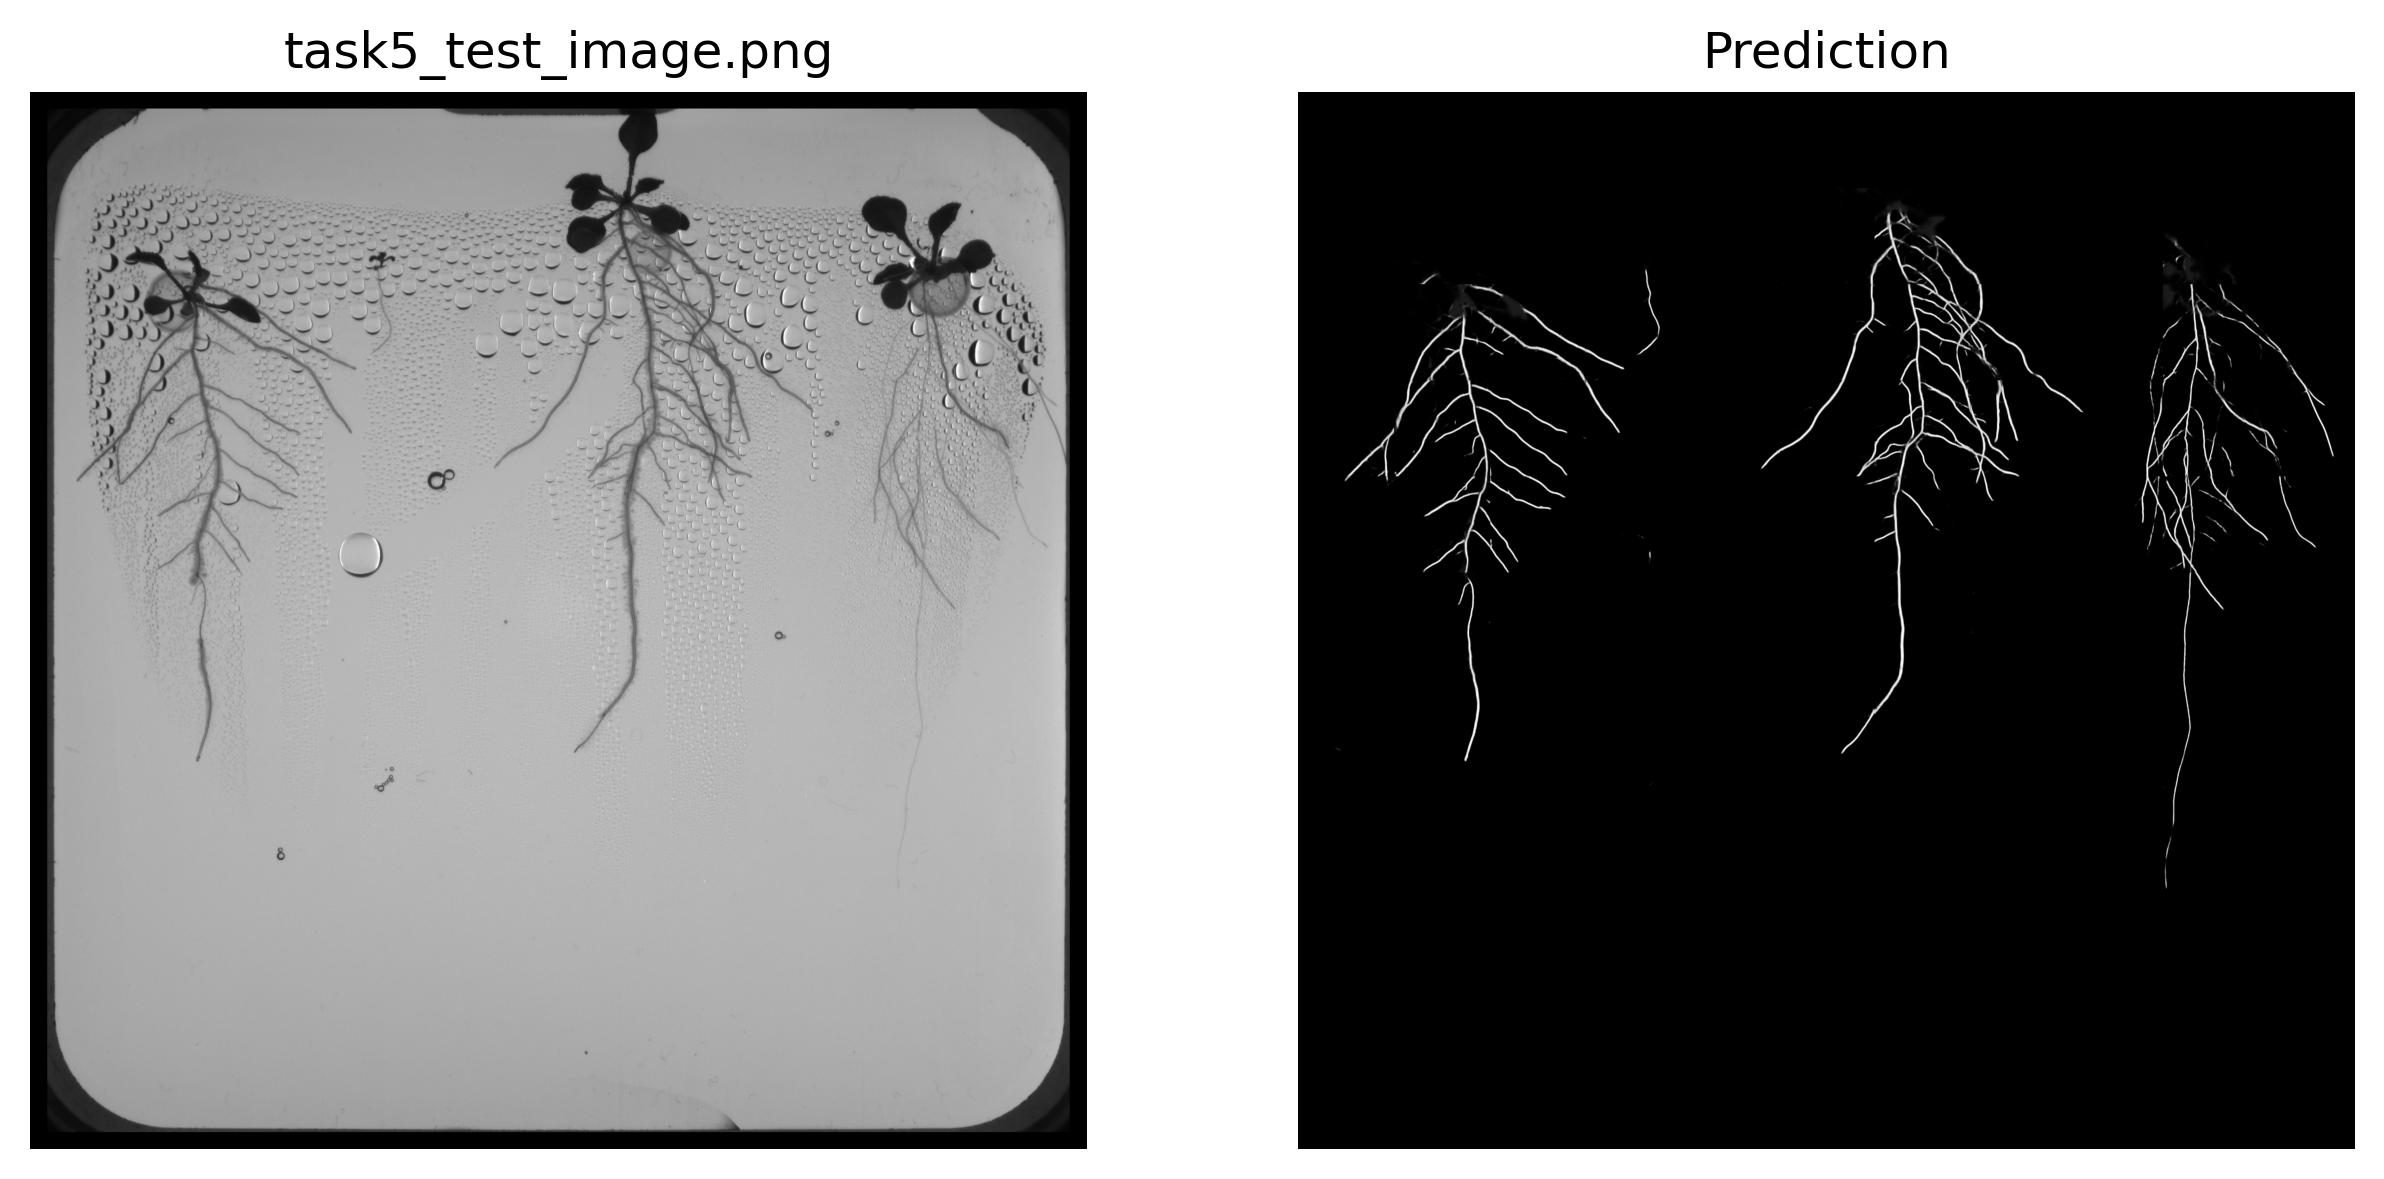

In [21]:
f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')

In [22]:
predicted_mask.shape

(2816, 2816)

In [23]:
predicted_mask.shape, image.shape

((2816, 2816), (3006, 4112, 3))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [24]:
import cv2
import numpy as np

def reverse_crop_and_padding(mask, original_size, bbox, patch_size):
    # extracting the dimensions
    height, width = original_size
    x, y, w, h = bbox

    # initializing a blank image with the original dimensions
    restored_image = np.zeros((height, width), dtype=mask.dtype)

    # reverse padding on the cropped mask first
    # calculating padding added during the padding operation
    padded_height = ((h // patch_size) + 1) * patch_size
    padded_width = ((w // patch_size) + 1) * patch_size

    # finding out how much was added to each side
    top_padding = (padded_height - h) // 2
    bottom_padding = padded_height - h - top_padding
    left_padding = (padded_width - w) // 2
    right_padding = padded_width - w - left_padding

    # remove the padding
    unpadded_mask = mask[top_padding:top_padding + h, left_padding:left_padding + w]

    # placing the unpadded mask into the correct position of the restored_image
    restored_image[y:y+h, x:x+w] = unpadded_mask

    return restored_image

petri_dish, bbox = crop_petri_dish(image)

original_size = (3006, 4112) 
patch_size = 128              

predicted_mask_corrected = reverse_crop_and_padding(img, original_size, bbox, patch_size)


NameError: name 'img' is not defined

In [ ]:
predicted_mask_corrected.shape

(3006, 4112)

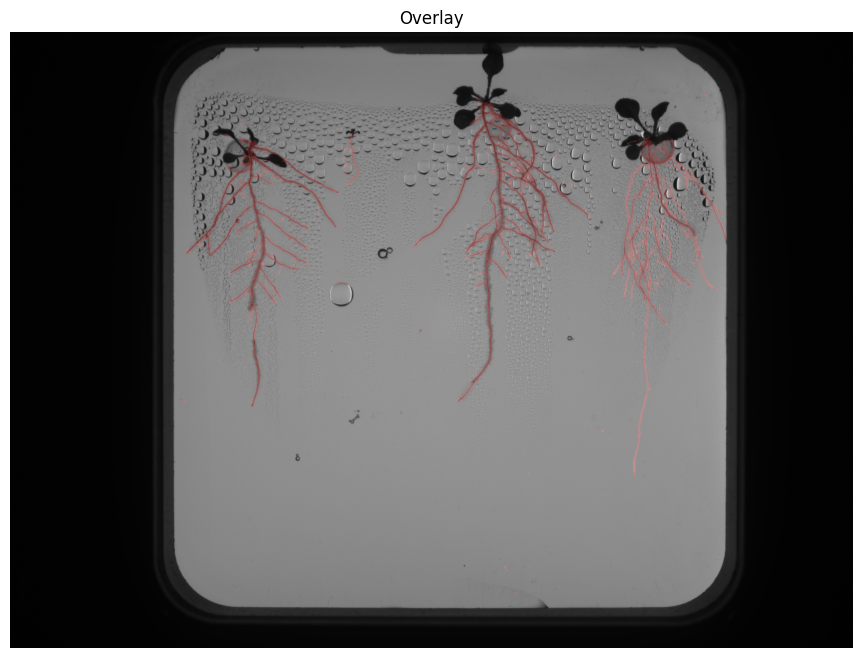

In [ ]:
# converting the mask to binary to make the overlay
_, binary_mask = cv2.threshold(predicted_mask_corrected, 1, 255, cv2.THRESH_BINARY)

# making a red-colored overlay mask
mask_colored = np.zeros_like(image)
mask_colored[:, :, 2] = binary_mask  # Set the red channel

# making the overlay
overlay = cv2.addWeighted(image, 0.8, mask_colored, 0.2, 0)

# plotting the mask, original image, and overlay
fig, ax = plt.subplots(figsize=(16, 8))  # Single subplot

ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
ax.set_title("Overlay")
ax.axis('off')

plt.show()

In [ ]:
if np.max(predicted_mask_corrected) <= 1:
    mask_to_save = (predicted_mask_corrected * 255).astype(np.uint8)
else:
    mask_to_save = predicted_mask_corrected.astype(np.uint8)

assert(predicted_mask_corrected.shape == image.shape)

cv2.imwrite('task5_test_image_prediction_emil_231007.png', mask_to_save)

True

In [ ]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
#mask_image = (predicted_mask_corrected * 255).astype(np.uint8)
#assert(predicted_mask_corrected.shape == image.shape)
#cv2.imwrite('task5_test_image_prediction_emil_2310077.png', mask_image)

Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.